# Cervical Cancer Analysis

Source data: https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#

## Background Information

There is convincing evidence that the following factors increase your risk for cervical cancer.

* Infection with human papillomavirus (HPV)

* Sexual activity

* Smoking

* Giving birth many times

* Infection with human immunodeficiency virus (HIV)

* History of sexually transmitted infections (STIs)

* Oral contraceptives

* Diethylstilbestrol (DES)

 Source: https://cancer.ca/en/cancer-information/cancer-types/cervical/risks

* (bool) Hinselmann: target variable
* (bool) Schiller: target variable
* (bool) Cytology: target variable
* (bool) Biopsy: target variable

## Import Libraries

In [1]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import re
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import RFECV

In [3]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import Rank2D
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [6]:
df = pd.read_csv('risk_factors_cervical_cancer.csv')

## Import Data

In [7]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

In [8]:
# Data types of each feature, object for some features indicated there are missing values
df.dtypes

Age                                    int64
Number of sexual partners             object
First sexual intercourse              object
Num of pregnancies                    object
Smokes                                object
Smokes (years)                        object
Smokes (packs/year)                   object
Hormonal Contraceptives               object
Hormonal Contraceptives (years)       object
IUD                                   object
IUD (years)                           object
STDs                                  object
STDs (number)                         object
STDs:condylomatosis                   object
STDs:cervical condylomatosis          object
STDs:vaginal condylomatosis           object
STDs:vulvo-perineal condylomatosis    object
STDs:syphilis                         object
STDs:pelvic inflammatory disease      object
STDs:genital herpes                   object
STDs:molluscum contagiosum            object
STDs:AIDS                             object
STDs:HIV  

In [9]:
# Replace the '?' with None type
df.replace({'?':None}, inplace=True)
df = df.fillna(value=np.nan)

In [10]:
# Show the number of missing values in ascending order
df.isnull().sum().sort_values(ascending=True)

Age                                     0
Schiller                                0
Hinselmann                              0
Dx                                      0
Dx:HPV                                  0
Dx:CIN                                  0
Dx:Cancer                               0
STDs: Number of diagnosis               0
Citology                                0
Biopsy                                  0
First sexual intercourse                7
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Number of sexual partners              26
Num of pregnancies                     56
STDs:HIV                              105
STDs:HPV                              105
STDs:Hepatitis B                      105
STDs:AIDS                             105
STDs:syphilis                         105
STDs:genital herpes                   105
STDs:pelvic inflammatory disease      105
STDs:vulvo-perineal condylomatosis

In [11]:
indicators = ['Biopsy', 'Citology','Hinselmann', 'Schiller']
y = df[indicators]
X = df.drop(columns = indicators)

In [12]:
X.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0,NaN,NaN,1,0,1,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0


## Save target data

In [13]:
y.head()

,Biopsy,Citology,Hinselmann,Schiller
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [14]:
y.value_counts()

Biopsy  Citology  Hinselmann  Schiller
0       0         0           0           756
        1         0           0            20
1       0         1           1            19
0       0         0           1            14
1       0         0           1            12
        1         0           1            11
                  1           1             6
        0         0           0             6
0       0         1           1             6
        1         1           1             3
                  0           1             3
1       1         0           0             1
0       0         1           0             1
dtype: int64

Condesing these target variables into a singular target based off of any one of them being True (positive)

In [15]:
y = y.astype(int)

In [16]:
y.head(10)

,Biopsy,Citology,Hinselmann,Schiller
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,1,0,1,1
7,0,0,0,0
8,0,0,0,0
9,0,0,0,0


In [17]:
y['result'] = y.any(axis=1)

In [18]:
y.head(30)

,Biopsy,Citology,Hinselmann,Schiller,result
0,0,0,0,0,False
1,0,0,0,0,False
2,0,0,0,0,False
3,0,0,0,0,False
4,0,0,0,0,False
5,0,0,0,0,False
6,1,0,1,1,True
7,0,0,0,0,False
8,0,0,0,0,False
9,0,0,0,0,False


In [19]:
y.to_csv('targets')

In [20]:
val_counts = y['result'].value_counts()

In [21]:
df_val_counts = pd.DataFrame(val_counts)

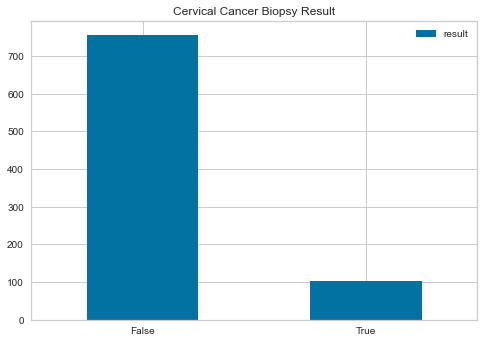

In [25]:
axes = df_val_counts.plot.bar(rot = 0, title = "Cervical Cancer Biopsy Result")

### X dataframe function

In [26]:
column_list = {0: "Age",
                   1: "Number of sexual partners",
                   2: "First sexual intercourse (age)",
                   3: "Num of pregnancies",
                   4: "Smokes",
                   5: "Smokes (years)",
                   6: "Smokes (packs/year)",
                   7: "Hormonal Contraceptives",
                   8: "Hormonal Contraceptives (years)",
                   9: "IUD",
                   10: "IUD (years)",
                   11: "STDs",
                   12: "STDs (number)",
                   13: "STDs:condylomatosis",
                   14: "STDs:cervical condylomatosis",
                   15: "STDs:vaginal condylomatosis",
                   16: "STDs:vulvo-perineal condylomatosis",
                   17: "STDs:syphilis",
                   18: "STDs:pelvic inflammatory disease",
                   19: "STDs:genital herpes",
                   20: "STDs:molluscum contagiosum",
                   21: "STDs:AIDS",
                   22: "STDs:HIV",
                   23: "STDs:Hepatitis B",
                   24: "STDs:HPV",
                   25: "STDs: Number of diagnosis",
                   26: "STDs: Time since first diagnosis",
                   27: "STDs: Time since last diagnosis",
                   28: "Dx:Cancer",
                   29: "Dx:CIN",
                   30: "Dx:HPV",
                   31: "Dx"}

In [27]:
def x_df(X):
    
    X_df = pd.DataFrame(X)
    X_df = X_df.astype({0: float,
               1: float,
               2: float,
               3: float,
               4: bool,
               5: float,
               6: float,
               7: bool,
               8: float,
               9: bool,
               10: float,
               11: bool,
               12: float,
               13: bool,
               14: bool,
               15: bool,
               16: bool,
               17: bool,
               18: bool,
               19: bool,
               20: bool,
               21: bool,
               22: bool,
               23: bool,
               24: bool,
               25: float,
               26: float,
               27: float,
               28: bool,
               29: bool,
               30: bool,
               31: bool}
         )
    column_list = {0: "Age",
                   1: "Number of sexual partners",
                   2: "First sexual intercourse (age)",
                   3: "Num of pregnancies",
                   4: "Smokes",
                   5: "Smokes (years)",
                   6: "Smokes (packs/year)",
                   7: "Hormonal Contraceptives",
                   8: "Hormonal Contraceptives (years)",
                   9: "IUD",
                   10: "IUD (years)",
                   11: "STDs",
                   12: "STDs (number)",
                   13: "STDs:condylomatosis",
                   14: "STDs:cervical condylomatosis",
                   15: "STDs:vaginal condylomatosis",
                   16: "STDs:vulvo-perineal condylomatosis",
                   17: "STDs:syphilis",
                   18: "STDs:pelvic inflammatory disease",
                   19: "STDs:genital herpes",
                   20: "STDs:molluscum contagiosum",
                   21: "STDs:AIDS",
                   22: "STDs:HIV",
                   23: "STDs:Hepatitis B",
                   24: "STDs:HPV",
                   25: "STDs: Number of diagnosis",
                   26: "STDs: Time since first diagnosis",
                   27: "STDs: Time since last diagnosis",
                   28: "Dx:Cancer",
                   29: "Dx:CIN",
                   30: "Dx:HPV",
                   31: "Dx"}

    X_df = X_df.rename(columns=column_list, errors="raise")
    return X_df

## Dataset 1: KNN inputation

Many of the missing values may be intentionally missing as all the questions are very personal. Thus KNN imputation was chosen as a method to fill the missing values. Since the dataset is relatively small the computation time is negligible, however outliers may cause a problem.

In [29]:
imputer = KNNImputer(n_neighbors = 29) #taken from sqrt(858) for K

In [30]:
X_imputed = x_df(imputer.fit_transform(X))

In [31]:
X_imputed.head()

,Age,Number of sexual partners,First sexual intercourse (age),Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,18.0,4.0,15.000000,1.0,False,0.0,0.0,False,0.0,False,...,False,False,False,0.0,3.172414,2.379310,False,False,False,False
1,15.0,1.0,14.000000,1.0,False,0.0,0.0,False,0.0,False,...,False,False,False,0.0,3.241379,2.448276,False,False,False,False
2,34.0,1.0,20.862069,1.0,False,0.0,0.0,False,0.0,False,...,False,False,False,0.0,7.310345,7.310345,False,False,False,False
3,52.0,5.0,16.000000,4.0,True,37.0,37.0,True,3.0,False,...,False,False,False,0.0,9.275862,8.655172,True,False,True,False
4,46.0,3.0,21.000000,4.0,False,0.0,0.0,True,15.0,False,...,False,False,False,0.0,8.689655,8.689655,False,False,False,False


In [32]:
X_imputed.dtypes

Age                                   float64
Number of sexual partners             float64
First sexual intercourse (age)        float64
Num of pregnancies                    float64
Smokes                                   bool
Smokes (years)                        float64
Smokes (packs/year)                   float64
Hormonal Contraceptives                  bool
Hormonal Contraceptives (years)       float64
IUD                                      bool
IUD (years)                           float64
STDs                                     bool
STDs (number)                         float64
STDs:condylomatosis                      bool
STDs:cervical condylomatosis             bool
STDs:vaginal condylomatosis              bool
STDs:vulvo-perineal condylomatosis       bool
STDs:syphilis                            bool
STDs:pelvic inflammatory disease         bool
STDs:genital herpes                      bool
STDs:molluscum contagiosum               bool
STDs:AIDS                         

In [33]:
X_imputed.to_csv('KNN_imputed_data.csv')

## Dataset 2: Simple Most frequent imputer

In [34]:
imp_mean = SimpleImputer(strategy='most_frequent') #for median imputation replace 'mean' with 'median'
imp_mean.fit(X)
X_imp_most_freq = imp_mean.transform(X)

In [35]:
X_imputed_mf = x_df(X_imp_most_freq)

In [36]:
X_imputed_mf.head()

,Age,Number of sexual partners,First sexual intercourse (age),Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,18.0,4.0,15.0,1.0,True,0.0,0.0,True,0.0,True,...,True,True,True,0.0,1.0,1.0,False,False,False,False
1,15.0,1.0,14.0,1.0,True,0.0,0.0,True,0.0,True,...,True,True,True,0.0,1.0,1.0,False,False,False,False
2,34.0,1.0,15.0,1.0,True,0.0,0.0,True,0.0,True,...,True,True,True,0.0,1.0,1.0,False,False,False,False
3,52.0,5.0,16.0,4.0,True,37.0,37.0,True,3.0,True,...,True,True,True,0.0,1.0,1.0,True,False,True,False
4,46.0,3.0,21.0,4.0,True,0.0,0.0,True,15.0,True,...,True,True,True,0.0,1.0,1.0,False,False,False,False


In [37]:
X_imputed_mf.dtypes

Age                                   float64
Number of sexual partners             float64
First sexual intercourse (age)        float64
Num of pregnancies                    float64
Smokes                                   bool
Smokes (years)                        float64
Smokes (packs/year)                   float64
Hormonal Contraceptives                  bool
Hormonal Contraceptives (years)       float64
IUD                                      bool
IUD (years)                           float64
STDs                                     bool
STDs (number)                         float64
STDs:condylomatosis                      bool
STDs:cervical condylomatosis             bool
STDs:vaginal condylomatosis              bool
STDs:vulvo-perineal condylomatosis       bool
STDs:syphilis                            bool
STDs:pelvic inflammatory disease         bool
STDs:genital herpes                      bool
STDs:molluscum contagiosum               bool
STDs:AIDS                         

In [38]:
X_imputed_mf.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse (age)        0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


In [39]:
X_imputed_mf.to_csv('frequent_imputed_data.csv')

## Dataset 3: Missing Values remain in place (for certain models)

In [40]:
X.to_csv('na_included_data.csv')

## Scaling Data

Since the dataset is relatively small, outliers can have a bigger impact on model accuracy. Thus, sklearn's Robust Scalar will be used to scale features so that it is not easily affected by outliers by removing the median and then using the interquartile range.

In [41]:
X_imputed_rs = RobustScaler().fit_transform(X_imputed)

In [42]:
X_imputed_rs = pd.DataFrame(X_imputed_rs)
X_imputed_rs = X_imputed_rs.rename(columns=column_list, errors="raise")

In [43]:
X_imputed_rs.head()

,Age,Number of sexual partners,First sexual intercourse (age),Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,-0.583333,2.0,-0.666667,-0.5,0.0,0.0,0.0,-1.0,-0.22,0.0,...,0.0,0.0,0.0,0.0,-0.247706,-0.361538,0.0,0.0,0.0,0.0
1,-0.833333,-1.0,-1.000000,-0.5,0.0,0.0,0.0,-1.0,-0.22,0.0,...,0.0,0.0,0.0,0.0,-0.229358,-0.346154,0.0,0.0,0.0,0.0
2,0.750000,-1.0,1.287356,-0.5,0.0,0.0,0.0,-1.0,-0.22,0.0,...,0.0,0.0,0.0,0.0,0.853211,0.738462,0.0,0.0,0.0,0.0
3,2.250000,3.0,-0.333333,1.0,1.0,37.0,37.0,0.0,0.78,0.0,...,0.0,0.0,0.0,0.0,1.376147,1.038462,1.0,0.0,1.0,0.0
4,1.750000,1.0,1.333333,1.0,0.0,0.0,0.0,0.0,4.78,0.0,...,0.0,0.0,0.0,0.0,1.220183,1.046154,0.0,0.0,0.0,0.0


In [44]:
X_imputed_mf_rs = RobustScaler().fit_transform(X_imputed_mf)

In [45]:
X_imputed_mf_rs = pd.DataFrame(X_imputed_mf_rs)
X_imputed_mf_rs = X_imputed_mf_rs.rename(columns=column_list, errors="raise")

In [46]:
X_imputed_mf_rs.head()

,Age,Number of sexual partners,First sexual intercourse (age),Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,-0.583333,2.0,-0.666667,-0.5,0.0,0.0,0.0,0.0,-0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.833333,-1.0,-1.000000,-0.5,0.0,0.0,0.0,0.0,-0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.750000,-1.0,-0.666667,-0.5,0.0,0.0,0.0,0.0,-0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.250000,3.0,-0.333333,1.0,0.0,37.0,37.0,0.0,1.375,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.750000,1.0,1.333333,1.0,0.0,0.0,0.0,0.0,7.375,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_rs = RobustScaler().fit_transform(X)

In [48]:
X_rs = pd.DataFrame(X_rs)
X_rs = X_rs.rename(columns=column_list, errors="raise")

In [49]:
X_rs.head()

,Age,Number of sexual partners,First sexual intercourse (age),Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,-0.583333,2.0,-0.666667,-0.5,0.0,0.0,0.0,-1.0,-0.166667,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,-0.833333,-1.0,-1.000000,-0.5,0.0,0.0,0.0,-1.0,-0.166667,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,0.750000,-1.0,NaN,-0.5,0.0,0.0,0.0,-1.0,-0.166667,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
3,2.250000,3.0,-0.333333,1.0,1.0,37.0,37.0,0.0,0.833333,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,0.0
4,1.750000,1.0,1.333333,1.0,0.0,0.0,0.0,0.0,4.833333,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0


## Pearson Ranking of Features

Identifying which features have a strong correlation with one another to justify inclusion or exclusion of features.

### Ranking for KNN

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


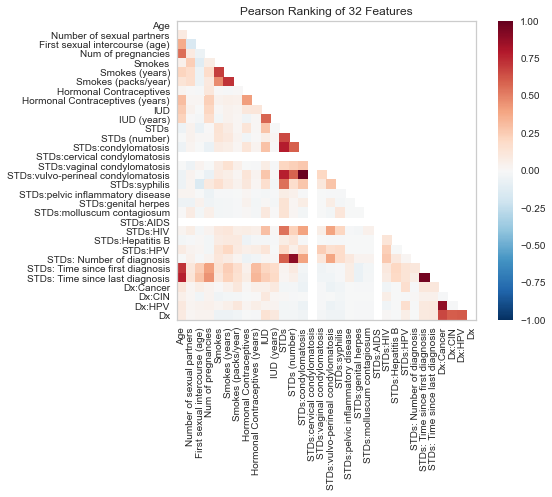

In [50]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X_imputed_rs)
visualizer.show();

Collinear features:
    
* STDs:vulvo-perineal condylomatosis & STDs:condylomatosis
* STDs: Number of diagnosis & STDs (number)
* STDs: Time since first diagnosis & STDs: Time since last diagnosis
* Dx:Cancer & Dx:HPV

These features are some of the strongest features correlated with each other.

### Ranking for Most Frequent

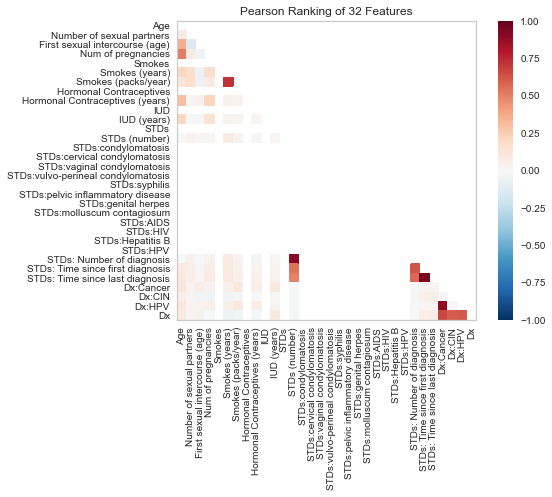

In [51]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X_imputed_mf_rs)
visualizer.show();

Collinear features:
    
* STDs: Number of diagnosis & STDs (number)
* Smokes (packs/year) & Smokes (years)
* STDs: Time since first diagnosis & STDs: Time since last diagnosis
* Dx:Cancer & Dx:HPV

These features are some of the strongest features correlated with each other.

## Feature Importance

In [56]:
# Removing characters from column names as lightGBM cannot handle them
X_rs_re = X_rs.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_imputed_rs_re = X_imputed_rs.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_imputed_mf_rs_re = X_imputed_mf_rs.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

[12:31:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


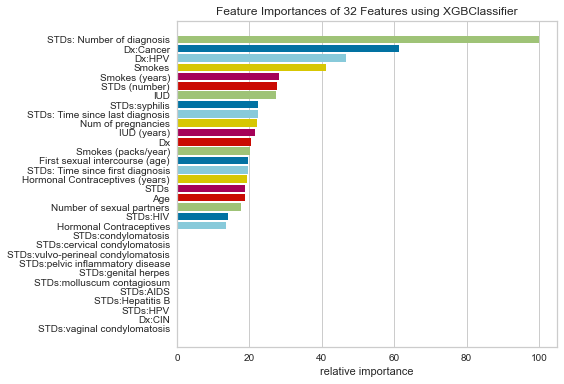

In [60]:
model = XGBClassifier(use_label_encoder=False)
viz = FeatureImportances(model)
viz.fit(X_imputed_rs, y['result'])
viz.show();

[12:31:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


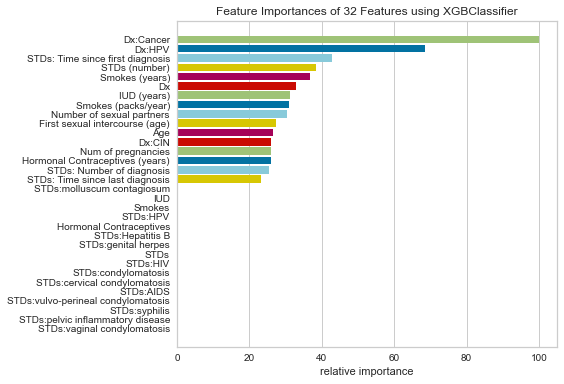

In [61]:
model = XGBClassifier(use_label_encoder=False)
viz = FeatureImportances(model)
viz.fit(X_imputed_mf_rs, y['result'])
viz.show();

[12:32:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


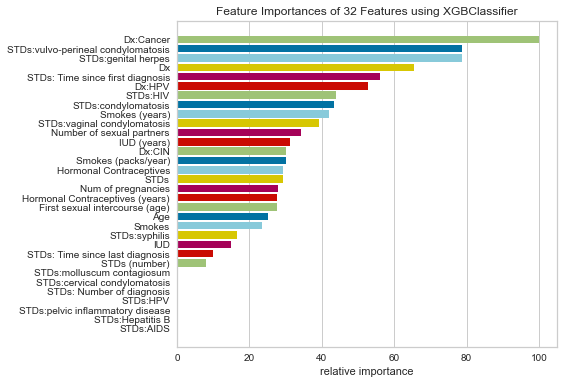

In [62]:
model = XGBClassifier(use_label_encoder=False)
viz = FeatureImportances(model)
viz.fit(X_rs, y['result'])
viz.show();

## Feature Selection

Considerations:
* Colinearity
* Feature Importance
* Data Availability (e.g. not many people will know their genetic testing information)

For the screener survey, there must be a balance for the number of questions. There must be limited number to encourage users to complete it and not feel overwhelmed, however it should obtain enough information to be informative.

In [63]:
features_limited = ['Age', 'Number of sexual partners', 'First sexual intercourse (age)', 'Num of pregnancies', 
                    'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)']

In [64]:
X_lim = X_imputed_rs[features_limited]

In [65]:
X_lim.head()

,Age,Number of sexual partners,First sexual intercourse (age),Num of pregnancies,Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number)
0,-0.583333,2.0,-0.666667,-0.5,0.0,-0.22,0.0,0.0
1,-0.833333,-1.0,-1.000000,-0.5,0.0,-0.22,0.0,0.0
2,0.750000,-1.0,1.287356,-0.5,0.0,-0.22,0.0,0.0
3,2.250000,3.0,-0.333333,1.0,37.0,0.78,0.0,0.0
4,1.750000,1.0,1.333333,1.0,0.0,4.78,0.0,0.0


## Train/Test Split

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_lim, y['result'], test_size=0.20, stratify =y['result'], random_state=42)

## Initial Modelling - 32 Features

In [68]:
# From https://www.scikit-yb.org/en/latest/tutorial.html with slight modification
def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    model = Pipeline([
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=[0, 1],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

In [69]:
models = [
    XGBClassifier(), #Extreme Gradient Boost Classifier
    lgb.LGBMClassifier() #LightGBM
]

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


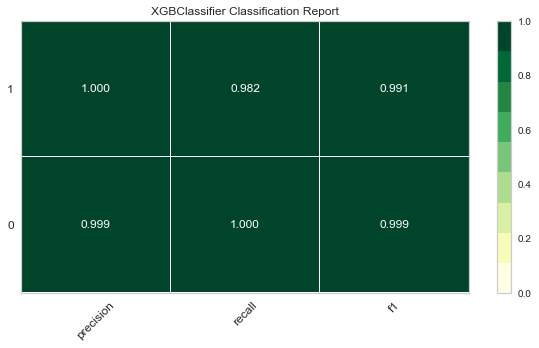

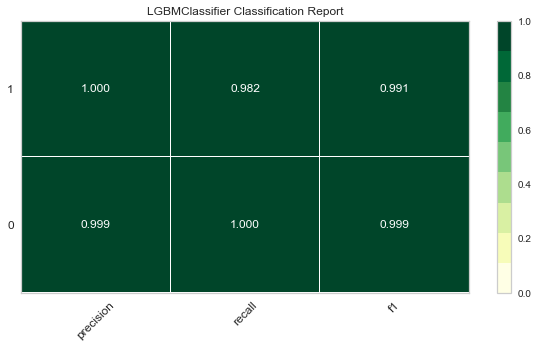

In [70]:
for model in models:
    visualize_model(X_imputed_rs_re, y['Biopsy'], model)

Using the f1 score metric as false postitives and false negatives are crucial in cancer diagnosis. Additionally since there is a class imbalance, the f1 score metric is more useful to consider than accuracy.

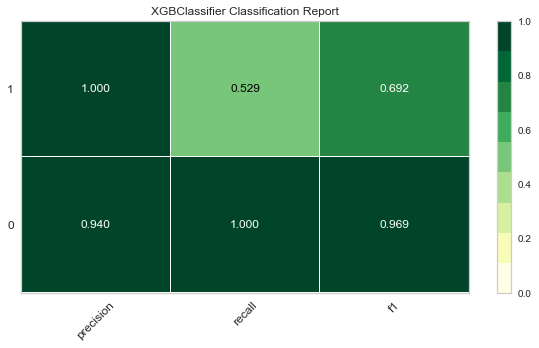

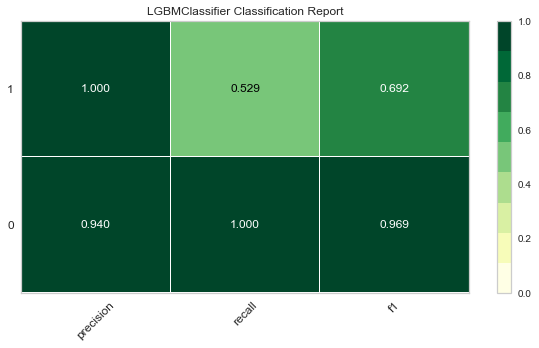

In [71]:
for model in models:
    visualize_model(X_imputed_rs_re, y['result'], model)

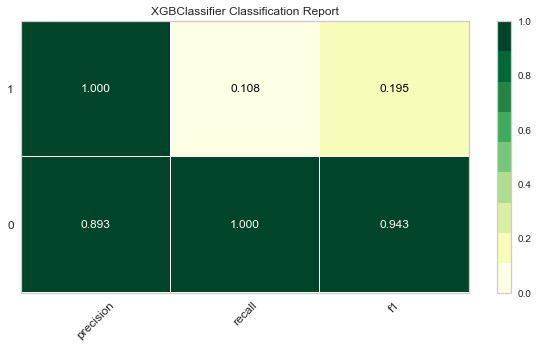

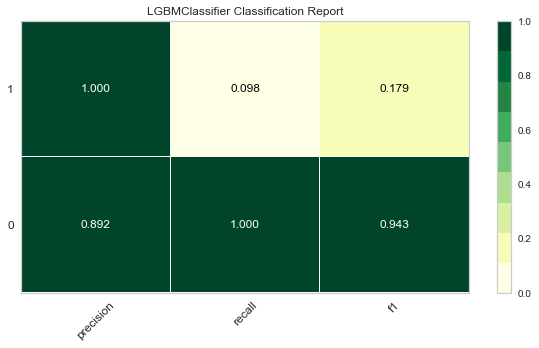

In [72]:
for model in models:
    visualize_model(X_imputed_mf_rs_re, y['result'], model)

In [73]:
models = [
    lgb.LGBMClassifier(),
    XGBClassifier() #Extreme Gradient Boost Classifier
]

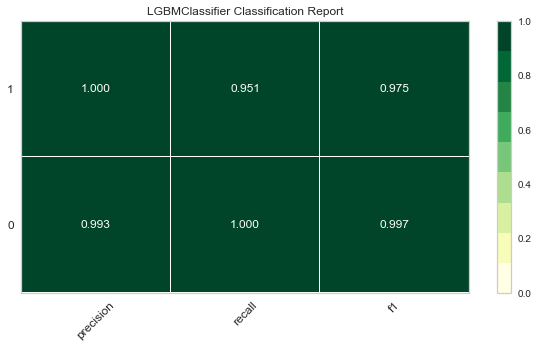

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


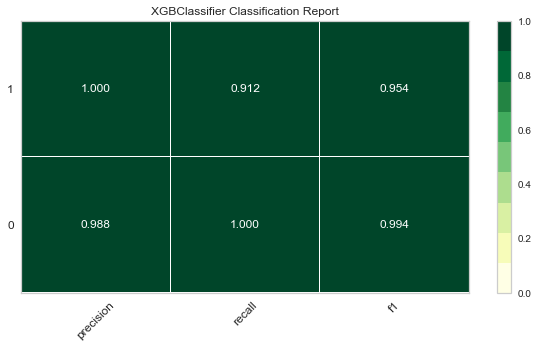

In [74]:
for model in models:
    visualize_model(X_rs_re, y['result'], model)

Decision: selecting the dataset that has no imputation (model automatic imputation) as the top scores are comparable to KNN imputation.

## Feature Elimination 

In [75]:
estimator = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', n_jobs=-1)

In [76]:
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_lim, y['result'])

In [77]:
selector.support_

array([False,  True,  True, False,  True, False,  True,  True])

In [78]:
selector.ranking_

array([4, 1, 1, 2, 1, 3, 1, 1])

In [79]:
#features_limited = ['Age', 'Number of sexual partners', 'First sexual intercourse (age)', 'Num of pregnancies', 
#                    'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)']

In [80]:
features_reduced = ['Number of sexual partners', 'First sexual intercourse (age)', 'Smokes (packs/year)',
                  'IUD (years)', 'STDs (number)']

In [81]:
X_red = X_imputed_rs[features_reduced]

Some people may be hesitant to input their 'Number of sexual partners' & 'First sexual intercourse (age)' so a more 'conservative' feature list is created below.

In [82]:
features_conservative = ['Age', 'Num of pregnancies', 
                        'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)']

In [83]:
X_cons = X_imputed_rs[features_conservative]

## Model Training

In [84]:
X_red_re = X_red.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_cons_re = X_cons.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_lim_re = X_lim.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### 5 Features

In [85]:
# From https://www.scikit-yb.org/en/latest/tutorial.html with slight modification
def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    model = Pipeline([
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=[0, 1],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

models = [
    XGBClassifier(), #Extreme Gradient Boost Classifier
]

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


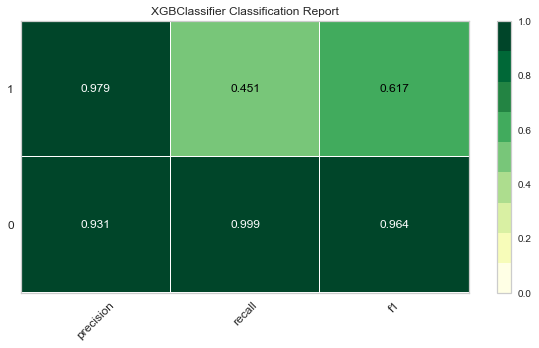

In [86]:
for model in models:
    visualize_model(X_red_re, y['result'], model)

Discussion: The positive class F1 score has fallen significantly - too many features have been eliminated.

### 8 Features

In [88]:
# From https://www.scikit-yb.org/en/latest/tutorial.html with slight modification
def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    model = Pipeline([
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=[0, 1],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

models = [
    XGBClassifier(), #Extreme Gradient Boost Classifier

]

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


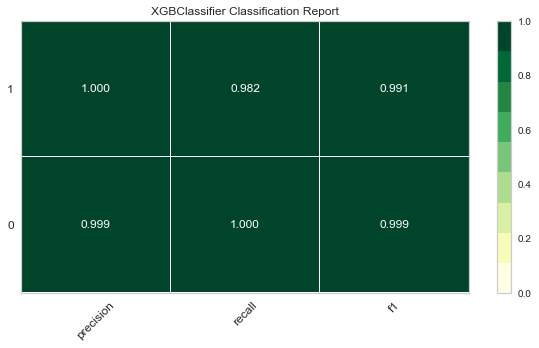

In [89]:
for model in models:
    visualize_model(X_imputed_rs, y['Biopsy'], model)

### Conservative Features

In [92]:
# From https://www.scikit-yb.org/en/latest/tutorial.html with slight modification
def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    model = Pipeline([
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=[0, 1],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

models = [
    XGBClassifier(), #Extreme Gradient Boost Classifier
]

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


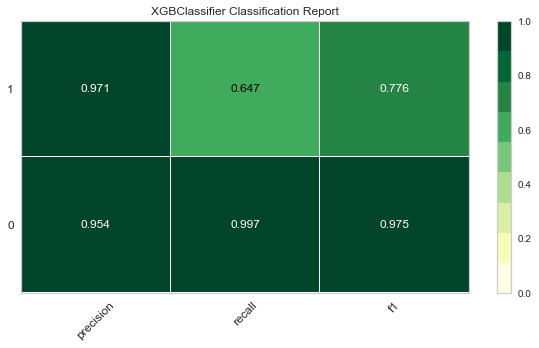

In [93]:
for model in models:
    visualize_model(X_cons_re, y['result'], model)

The scores are certainly better than with 5 features, however they do not compare well to the 8 feature models. Thus, having a few more questions is worth the gain in recall and precision. This initial modelling is likely overfit, however it gives a good indication of which direction to go in. From this, 8 features will be used and Random Search will be used to hyperparameter tune and improve regularization.